In [1]:
import numpy as np
import pickle as pkl
import re
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from pyspark.mllib.clustering import KMeans
from collections import Counter
from nltk.corpus import stopwords
import string
import pyspark as ps    # for the pyspark suite
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, StringType
import unicodedata
import nltk

from nltk.tokenize import sent_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.util import ngrams
from nltk import pos_tag
from nltk import RegexpParser

from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF

import sys
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, RegexTokenizer, StopWordsRemover, NGram, \
        CountVectorizer, IDF, Word2Vec
from pyspark.sql.functions import udf, col, explode, collect_list, to_date, concat
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, \
        FloatType, ArrayType, BooleanType
from nltk.stem import SnowballStemmer





In [2]:
df_full = spark.read.csv('s3a://usfocus/congress_full.csv',header = True,inferSchema=True,sep=",")


In [3]:
df_full.printSchema()

root
 |-- content: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- dates: string (nullable = true)
 |-- name: string (nullable = true)
 |-- congress: double (nullable = true)



In [4]:
tokenizer = RegexTokenizer(inputCol="content", outputCol="tokens", pattern="\\W", minTokenLength=3)

remover = StopWordsRemover(inputCol="tokens", outputCol='tokens_nostopwords')

from pyspark import keyword_only
from pyspark.ml.util import Identifiable
from pyspark.ml.pipeline import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
from nltk.stem import SnowballStemmer
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

# Custom stemming transformer class for pyspark
class Stemming_Transformer(Transformer, HasInputCol, HasOutputCol):
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None):
        super(Stemming_Transformer, self).__init__()
        kwargs = self.__init__._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(self, inputCol=None, outputCol=None, language='english', ):
        kwargs = self.setParams._input_kwargs
        return self._set(**kwargs)

    def _transform(self, dataset):
        opinion_stemm = SnowballStemmer('english')
        udfStemmer = udf(lambda tokens: [opinion_stemm.stem(word) for word in tokens], ArrayType(StringType()))

        inCol = self.getInputCol()
        outCol = self.getOutputCol()

        return dataset.withColumn(outCol, udfStemmer(inCol))

stemmer = Stemming_Transformer(inputCol='tokens_nostopwords', outputCol='tokens_stemmed')
grams2 = NGram(n=2 , inputCol='tokens_stemmed', outputCol='tokens_2grams' )
grams3 = NGram(n=3 , inputCol='tokens_stemmed', outputCol='tokens_3grams' )

cv_2grams = CountVectorizer(inputCol='tokens_2grams', outputCol='tokens2grams_countvectorized', minDF=2.0,vocabSize=3000)
cv_3grams = CountVectorizer(inputCol='tokens_3grams', outputCol='tokens3grams_countvectorized', minDF=2.0,vocabSize=3000)

idf_2grams = IDF(inputCol='tokens2grams_countvectorized', outputCol='token2grams_idf')
idf_3grams = IDF(inputCol='tokens3grams_countvectorized', outputCol='token3grams_idf')


In [5]:
pipe_stem = Pipeline(stages=[tokenizer, remover, stemmer])


In [6]:
model_stem = pipe_stem.fit(df_full)

df_stem = model_stem.transform(df_full)


In [7]:
df_stem.printSchema()

root
 |-- content: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- dates: string (nullable = true)
 |-- name: string (nullable = true)
 |-- congress: double (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_nostopwords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_stemmed: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [8]:
df_grams2 = grams2.transform(df_stem)

In [9]:
df_grams2.printSchema()

root
 |-- content: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- dates: string (nullable = true)
 |-- name: string (nullable = true)
 |-- congress: double (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_nostopwords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_stemmed: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_2grams: array (nullable = true)
 |    |-- element: string (containsNull = false)



In [10]:
#df_grams3 = grams3.transform(df_grams2)

In [11]:
#df_grams3.printSchema()

In [10]:
cv_model_2grams = cv_2grams.fit(df_grams2)

In [11]:
df2grams_countvector = cv_model_2grams.transform(df_grams2)

In [12]:
Vocab_2grams = cv_model_2grams.vocabulary

In [13]:
len(Vocab_2grams)

3000

In [14]:
Vocab_2grams[2]

u'secretari shall'

In [15]:
model_idf2grams = idf_2grams.fit(df2grams_countvector)

df_tfidf_2grams = model_idf2grams.transform(df2grams_countvector)

In [16]:
df_tfidf_2grams.printSchema()

root
 |-- content: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- dates: string (nullable = true)
 |-- name: string (nullable = true)
 |-- congress: double (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_nostopwords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_stemmed: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_2grams: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- tokens2grams_countvectorized: vector (nullable = true)
 |-- token2grams_idf: vector (nullable = true)



In [17]:

sub_list =['Health',
 'Government+Operations+and+Politics',
 'Taxation',
 'Armed+Forces+and+National+Security',
 'Public+Lands+and+Natural+Resources',
 'International+Affairs',
 'Congress',
 'Crime+and+Law+Enforcement',
 'Immigration',
 'Science,+Technology,+Communications',
 'Education',
 'Finance+and+Financial+Sector',
 'Environmental+Protection',
 'Labor+and+Employment',
 'Transportation+and+Public+Works',
 'Energy',
 'Civil+Rights+and+Liberties,+Minority+Issues',
 'Emergency+Management',
 'Law',
 'Economics+and+Public+Finance',
 'Commerce',
 'Native+Americans',
 'Housing+and+Community+Development',
 'Social+Welfare',
 'Water+Resources+Development',
 'Agriculture+and+Food',
 'Animals',
 'Foreign+Trade+and+International+Finance',
 'Families',
 'Sports+and+Recreation',
 'Arts,+Culture,+Religion',
 'Social+Sciences+and+History']

sub_dict = {}
for i in range(len(sub_list)):
    sub_dict[sub_list[i]] = i

sub_dict



{'Agriculture+and+Food': 25,
 'Animals': 26,
 'Armed+Forces+and+National+Security': 3,
 'Arts,+Culture,+Religion': 30,
 'Civil+Rights+and+Liberties,+Minority+Issues': 16,
 'Commerce': 20,
 'Congress': 6,
 'Crime+and+Law+Enforcement': 7,
 'Economics+and+Public+Finance': 19,
 'Education': 10,
 'Emergency+Management': 17,
 'Energy': 15,
 'Environmental+Protection': 12,
 'Families': 28,
 'Finance+and+Financial+Sector': 11,
 'Foreign+Trade+and+International+Finance': 27,
 'Government+Operations+and+Politics': 1,
 'Health': 0,
 'Housing+and+Community+Development': 22,
 'Immigration': 8,
 'International+Affairs': 5,
 'Labor+and+Employment': 13,
 'Law': 18,
 'Native+Americans': 21,
 'Public+Lands+and+Natural+Resources': 4,
 'Science,+Technology,+Communications': 9,
 'Social+Sciences+and+History': 31,
 'Social+Welfare': 23,
 'Sports+and+Recreation': 29,
 'Taxation': 2,
 'Transportation+and+Public+Works': 14,
 'Water+Resources+Development': 24}

In [19]:
df_presidential = spark.read.json('s3a://usfocus/presidential-full-final.json')

In [20]:
df_presidential.count()

975

In [21]:
df_presidential = df_presidential.filter(df_presidential['content'] != 'null')

In [22]:
df_presidential.count()

974

In [23]:
model_stem_pre = pipe_stem.fit(df_presidential)

In [24]:
df_pres_stem = model_stem_pre.transform(df_presidential)

In [25]:
df_pre_2grams = grams2.transform(df_pres_stem)

In [26]:
Vector_presidential_2grams = cv_model_2grams.transform(df_pre_2grams)

In [27]:
Vector_presidential_2grams.printSchema()

root
 |-- _corrupt_record: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- $oid: string (nullable = true)
 |-- content: string (nullable = true)
 |-- date: string (nullable = true)
 |-- link: string (nullable = true)
 |-- speech_title: string (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_nostopwords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_stemmed: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_2grams: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- tokens2grams_countvectorized: vector (nullable = true)



In [28]:
df_tfidf_pre_2grams = model_idf2grams.transform(Vector_presidential_2grams)

In [29]:
df_tfidf_pre_2grams.printSchema()

root
 |-- _corrupt_record: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- $oid: string (nullable = true)
 |-- content: string (nullable = true)
 |-- date: string (nullable = true)
 |-- link: string (nullable = true)
 |-- speech_title: string (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_nostopwords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_stemmed: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_2grams: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- tokens2grams_countvectorized: vector (nullable = true)
 |-- token2grams_idf: vector (nullable = true)



In [18]:
topicWord=udf(lambda tkn: sub_dict[tkn],IntegerType())

In [19]:
df_tfidf_2grams=df_tfidf_2grams.withColumn("label",topicWord(df_tfidf_2grams.subject))

In [20]:
df_tfidf_2grams.printSchema()

root
 |-- content: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- dates: string (nullable = true)
 |-- name: string (nullable = true)
 |-- congress: double (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_nostopwords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_stemmed: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_2grams: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- tokens2grams_countvectorized: vector (nullable = true)
 |-- token2grams_idf: vector (nullable = true)
 |-- label: integer (nullable = true)



In [35]:
#df_tfidf.write.json('s3a://usfocus/congress_tfidf_2nd.json')

In [21]:
from pyspark.ml.classification import NaiveBayes

In [22]:
nb = NaiveBayes(smoothing=1.0, modelType="multinomial",featuresCol="token2grams_idf", labelCol="label")

In [69]:
splits = df_tfidf_2grams.randomSplit([0.7, 0.3])

In [70]:
df_train = splits[0]
df_test = splits[1]

In [71]:
#df_train.count(), df_test.count(), df_transformed.count()

In [72]:
df_train.persist()

DataFrame[content: string, subject: string, dates: string, name: string, congress: double, tokens: array<string>, tokens_nostopwords: array<string>, tokens_stemmed: array<string>, tokens_2grams: array<string>, tokens2grams_countvectorized: vector, token2grams_idf: vector, label: int]

In [73]:
df_test.persist()

DataFrame[content: string, subject: string, dates: string, name: string, congress: double, tokens: array<string>, tokens_nostopwords: array<string>, tokens_stemmed: array<string>, tokens_2grams: array<string>, tokens2grams_countvectorized: vector, token2grams_idf: vector, label: int]

In [28]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [29]:
model = nb.fit(df_train)

# apply the model on the test setM
result = model.transform(df_test)

In [30]:
# keep only label and prediction to compute accuracy
predictionAndLabels = result.select("prediction", "label")

# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                                  metricName="accuracy")

print("Accuracy: {}".format(evaluator.evaluate(predictionAndLabels)))

Accuracy: 0.740132656404


In [49]:
thetaarray = model.theta.toArray().T

In [ ]:
import numpy as np

In [ ]:
1+1

In [51]:
thetaarray.shape

(5000, 32)

In [52]:
thetaarray[0]

array([-6.44590418, -6.43343054, -5.85717183, -6.52351288, -7.02232651,
       -7.08194578, -6.85005214, -6.53172559, -6.29349743, -6.92021564,
       -6.64341211, -6.49222054, -6.73765527, -6.28748885, -6.48646872,
       -6.71948854, -6.67430144, -6.7454701 , -6.58944382, -6.53970928,
       -6.59213549, -6.85835928, -6.28178018, -6.25293172, -7.0096497 ,
       -6.66029902, -6.72710336, -6.72332243, -6.44808934, -7.16209552,
       -7.06001318, -8.58070375])

In [31]:
from sklearn.metrics import confusion_matrix

In [32]:
result.printSchema()

root
 |-- content: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- dates: string (nullable = true)
 |-- name: string (nullable = true)
 |-- congress: double (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_nostopwords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_stemmed: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_2grams: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- tokens2grams_countvectorized: vector (nullable = true)
 |-- token2grams_idf: vector (nullable = true)
 |-- label: integer (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)



In [33]:
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.PuRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=8,fontweight='heavy',rotation=90)
    plt.yticks(tick_marks, classes,fontsize=8,fontweight='heavy')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    #for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    #    plt.text(j, i, cm[i, j],
    #             horizontalalignment="center",
    #             color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.figure(figsize=(20,20),dpi=1000)


In [34]:
true_label = result.select('label').collect()

predict_label = result.select('prediction').collect()

In [35]:
len(true_label),len(predict_label)

(24424, 24424)

In [36]:
confusion_matrix_nb = confusion_matrix(np.array(true_label), np.array(predict_label))

In [37]:
confusion_matrix_nb

array([[1569,    7,   14, ...,   24,    1,   79],
       [  15,  996,   13, ...,   38,   19,  100],
       [  15,   20, 2175, ...,    3,    0,   13],
       ..., 
       [   0,    0,    0, ...,   32,    0,   15],
       [   0,    0,    0, ...,    0,   41,   39],
       [   0,    0,    0, ...,    0,    0,   32]])

In [38]:
subject_ordered = sorted(sub_dict,key=sub_dict.get)

In [39]:
label_list=range(0,32)

Normalized confusion matrix
[[  7.52157239e-01   3.35570470e-03   6.71140940e-03 ...,   1.15052733e-02
    4.79386385e-04   3.78715244e-02]
 [  8.30564784e-03   5.51495017e-01   7.19822813e-03 ...,   2.10409745e-02
    1.05204873e-02   5.53709856e-02]
 [  6.39931741e-03   8.53242321e-03   9.27901024e-01 ...,   1.27986348e-03
    0.00000000e+00   5.54607509e-03]
 ..., 
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   4.44444444e-01
    0.00000000e+00   2.08333333e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    3.62831858e-01   3.45132743e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   9.69696970e-01]]


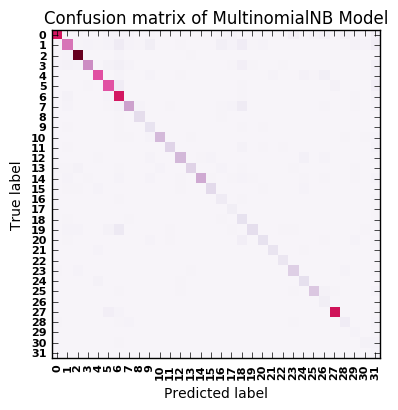

In [40]:
plot_confusion_matrix(confusion_matrix_nb,classes = label_list,normalize = True, title = 'Confusion matrix of MultinomialNB Model')

In [209]:
#df_tfidf.write.json('s3a://usfocus/congress_tfidf.json')

In [ ]:
#result.write.json('s3a://usfocus/result_tfidf.csv')

In [63]:
result_presidential = model.transform(df_tfidf_pre)

In [64]:
result_presidential = result_presidential.select('content','date','link','speech_title','tokens_countvectorized','tokens_stemmed','token_idf','rawPrediction','probability','prediction')

In [65]:
result_presidential.printSchema()

root
 |-- content: string (nullable = true)
 |-- date: string (nullable = true)
 |-- link: string (nullable = true)
 |-- speech_title: string (nullable = true)
 |-- tokens_countvectorized: vector (nullable = true)
 |-- tokens_stemmed: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- token_idf: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)



In [66]:
result_presidential.write.json('s3a://usfocus/result_presidential_tfidf.json')

In [74]:
from pyspark.ml.classification import LogisticRegression

In [75]:
LG = LogisticRegression(featuresCol="token2grams_idf", labelCol="label")

In [76]:
model_lg = LG.fit(df_train)

# apply the model on the test setM
result_lg = model_lg.transform(df_test)

In [77]:
result_lg.printSchema()

root
 |-- content: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- dates: string (nullable = true)
 |-- name: string (nullable = true)
 |-- congress: double (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_nostopwords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_stemmed: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_2grams: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- tokens2grams_countvectorized: vector (nullable = true)
 |-- token2grams_idf: vector (nullable = true)
 |-- label: integer (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)



In [78]:
# keep only label and prediction to compute accuracy
predictionAndLabels_lg = result_lg.select("prediction", "label")

# compute accuracy on the test set
evaluator_lg = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                                  metricName="accuracy")

print("Accuracy: {}".format(evaluator_lg.evaluate(predictionAndLabels_lg)))

Accuracy: 0.842786479802


In [79]:
predict_label_lg = result_lg.select('prediction').collect()

In [80]:
len(true_label),len(predict_label_lg)

(24424, 24260)

In [51]:
confusion_matrix_lg = confusion_matrix(np.array(true_label), np.array(predict_label_lg))

In [52]:
confusion_matrix_lg

array([[2010,    7,    6, ...,    3,    4,    0],
       [   6, 1660,    2, ...,    2,    2,    0],
       [   3,    4, 2311, ...,    0,    0,    0],
       ..., 
       [   3,    1,    0, ...,   51,    0,    0],
       [   5,   12,    0, ...,    1,   74,    0],
       [   0,    6,    0, ...,    1,    3,   14]])

Normalized confusion matrix
[[ 0.96356663  0.0033557   0.00287632 ...,  0.00143816  0.00191755  0.        ]
 [ 0.00332226  0.91915836  0.00110742 ...,  0.00110742  0.00110742  0.        ]
 [ 0.00127986  0.00170648  0.9859215  ...,  0.          0.          0.        ]
 ..., 
 [ 0.04166667  0.01388889  0.         ...,  0.70833333  0.          0.        ]
 [ 0.04424779  0.10619469  0.         ...,  0.00884956  0.65486726  0.        ]
 [ 0.          0.18181818  0.         ...,  0.03030303  0.09090909
   0.42424242]]


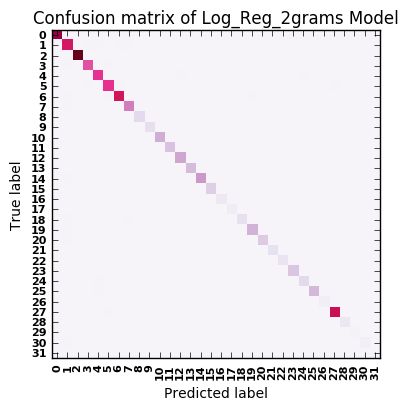

In [68]:
plot_confusion_matrix(confusion_matrix_lg, classes = label_list,normalize = True, title = 'Confusion matrix of Log_Reg_2grams Model')

In [54]:
from pyspark.ml.classification import RandomForestClassifier

In [55]:
rf = RandomForestClassifier(featuresCol="token2grams_idf", labelCol="label")

In [56]:
model_rf = rf.fit(df_train)

# apply the model on the test setM
result_rf = model_rf.transform(df_test)

In [57]:
result_rf.printSchema()

root
 |-- content: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- dates: string (nullable = true)
 |-- name: string (nullable = true)
 |-- congress: double (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_nostopwords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_stemmed: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_2grams: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- tokens2grams_countvectorized: vector (nullable = true)
 |-- token2grams_idf: vector (nullable = true)
 |-- label: integer (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)



In [58]:
# keep only label and prediction to compute accuracy
predictionAndLabels_rf = result_rf.select("prediction", "label")

# compute accuracy on the test set
evaluator_rf = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                                  metricName="accuracy")

print("Accuracy: {}".format(evaluator_rf.evaluate(predictionAndLabels_rf)))

Accuracy: 0.448861775303


In [59]:
predict_label_rf = result_rf.select('prediction').collect()

In [60]:


len(true_label),len(predict_label_rf)

(24424, 24424)

In [61]:
confusion_matrix_rf = confusion_matrix(np.array(true_label), np.array(predict_label_rf))

In [62]:
confusion_matrix_rf

array([[1768,  148,   53, ...,    0,    0,    0],
       [ 128, 1365,  113, ...,    0,    0,    0],
       [  22,   60, 2228, ...,    0,    0,    0],
       ..., 
       [   9,   35,    1, ...,    0,    0,    0],
       [   6,   76,    0, ...,    0,    0,    0],
       [   1,   24,    0, ...,    0,    0,    0]])

Normalized confusion matrix
[[ 0.84755513  0.07094919  0.02540748 ...,  0.          0.          0.        ]
 [ 0.07087486  0.75581395  0.06256921 ...,  0.          0.          0.        ]
 [ 0.00938567  0.02559727  0.95051195 ...,  0.          0.          0.        ]
 ..., 
 [ 0.125       0.48611111  0.01388889 ...,  0.          0.          0.        ]
 [ 0.05309735  0.67256637  0.         ...,  0.          0.          0.        ]
 [ 0.03030303  0.72727273  0.         ...,  0.          0.          0.        ]]


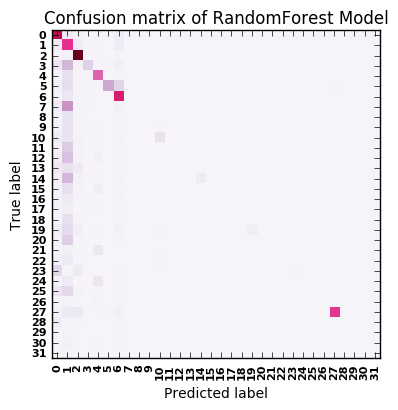

In [63]:
plot_confusion_matrix(confusion_matrix_rf, classes = label_list,normalize = True, title = 'Confusion matrix of RandomForest Model')

In [93]:
result_presidential.show()

+--------------------+------------------+--------------------+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+----------+
|             content|              date|                link|        speech_title|tokens_countvectorized|      tokens_stemmed|           token_idf|       rawPrediction|         probability|prediction|
+--------------------+------------------+--------------------+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+----------+
|Thank you.  (Appl...|    March 22, 2016|https://millercen...| Remarks to the P...|  (5000,[2,8,10,11,...|[thank, applaus, ...|(5000,[2,8,10,11,...|[-42859.721236114...|[0.0,0.0,0.0,0.0,...|       5.0|
|Mr. Speaker, Mr. ...|  January 12, 2016|https://millercen...| 2016 State of th...|  (5000,[2,3,8,9,10...|[speaker, vice, p...|(5000,[2,3,8,9,10...|[-59222.646246769...|[0.0,0.0,0.0,0.0,...|  

In [97]:
result_presidential.printSchema()

root
 |-- content: string (nullable = true)
 |-- date: string (nullable = true)
 |-- link: string (nullable = true)
 |-- speech_title: string (nullable = true)
 |-- tokens_countvectorized: vector (nullable = true)
 |-- tokens_stemmed: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- token_idf: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)



In [66]:
subject_ordered[0:8], subject_ordered[27] 

(['Health',
  'Government+Operations+and+Politics',
  'Taxation',
  'Armed+Forces+and+National+Security',
  'Public+Lands+and+Natural+Resources',
  'International+Affairs',
  'Congress',
  'Crime+and+Law+Enforcement'],
 'Foreign+Trade+and+International+Finance')

In [67]:
subject_ordered[28:]

['Families',
 'Sports+and+Recreation',
 'Arts,+Culture,+Religion',
 'Social+Sciences+and+History']

In [103]:
table_presidential_date_topic = result_presidential.select('date','prediction')

In [104]:
table_presidential_date_topic.show()

+------------------+----------+
|              date|prediction|
+------------------+----------+
|    March 22, 2016|       5.0|
|  January 12, 2016|       5.0|
|     June 26, 2015|      31.0|
|     March 7, 2015|      31.0|
|  January 20, 2015|       5.0|
| November 20, 2014|       5.0|
|  January 28, 2014|       5.0|
|  December 4, 2013|       5.0|
|September 10, 2013|       5.0|
|     July 24, 2013|      10.0|
|     July 13, 2013|       7.0|
|     April 8, 2013|       7.0|
|    March 21, 2013|       5.0|
|     March 1, 2013|       5.0|
| February 13, 2013|       5.0|
|  January 29, 2013|      31.0|
|  January 21, 2013|      31.0|
| December 16, 2012|       7.0|
|  November 6, 2012|      31.0|
| September 6, 2012|       5.0|
+------------------+----------+
only showing top 20 rows



In [107]:
table_presidential_date_topic.printSchema()

root
 |-- date: string (nullable = true)
 |-- prediction: double (nullable = true)



In [128]:
extract_year=udf(lambda date: int(date.split()[-1].encode('utf-8')), IntegerType())

In [129]:
table_presidential_date_topic = table_presidential_date_topic.withColumn('year', extract_year(table_presidential_date_topic.date))

In [130]:
table_presidential_date_topic.take(2)

[Row(date=u'March 22, 2016', prediction=5.0, year=2016),
 Row(date=u'January 12, 2016', prediction=5.0, year=2016)]

In [131]:
extract_month=udf(lambda date: date.split()[0].encode('utf-8'), StringType())

In [132]:
table_presidential_date_topic = table_presidential_date_topic.withColumn('month', extract_month(table_presidential_date_topic.date))

In [133]:
table_presidential_date_topic.show()

+------------------+----------+----+---------+
|              date|prediction|year|    month|
+------------------+----------+----+---------+
|    March 22, 2016|       5.0|2016|    March|
|  January 12, 2016|       5.0|2016|  January|
|     June 26, 2015|      31.0|2015|     June|
|     March 7, 2015|      31.0|2015|    March|
|  January 20, 2015|       5.0|2015|  January|
| November 20, 2014|       5.0|2014| November|
|  January 28, 2014|       5.0|2014|  January|
|  December 4, 2013|       5.0|2013| December|
|September 10, 2013|       5.0|2013|September|
|     July 24, 2013|      10.0|2013|     July|
|     July 13, 2013|       7.0|2013|     July|
|     April 8, 2013|       7.0|2013|    April|
|    March 21, 2013|       5.0|2013|    March|
|     March 1, 2013|       5.0|2013|    March|
| February 13, 2013|       5.0|2013| February|
|  January 29, 2013|      31.0|2013|  January|
|  January 21, 2013|      31.0|2013|  January|
| December 16, 2012|       7.0|2012| December|
|  November 6

In [161]:
table_presidential_date_topic.createOrReplaceTempView('table_pre_date_topic')

In [215]:
table_grouped1 = spark.sql("SELECT prediction,count(prediction) as count FROM table_pre_date_topic GROUP BY prediction ORDER BY count DESC")

In [217]:
table_grouped1.count()

24

In [218]:
result_presidential.count()

974

In [219]:
subject_ordered[5], subject_ordered[31]

('International+Affairs', 'Social+Sciences+and+History')

In [ ]:
table_grouped1.show()

+----------+-----+
|prediction|count|
+----------+-----+
|       5.0|  662|
|      31.0|  158|
|       1.0|   41|
|       7.0|   21|
|      11.0|   12|
|      27.0|   11|
|       6.0|    9|
|      21.0|    7|
|      14.0|    7|
|       0.0|    5|
|       4.0|    5|
|      25.0|    5|
|       3.0|    4|
|      19.0|    4|
|      10.0|    3|
|      16.0|    3|
|       8.0|    3|
|      15.0|    3|
|      13.0|    3|
|      18.0|    3|
+----------+-----+
only showing top 20 rows



In [175]:
df_full.show()

+--------------------+-------+----------+--------------------+--------+
|             content|subject|     dates|                name|congress|
+--------------------+-------+----------+--------------------+--------+
|  HR 5961 IH 101s...| Health|12/03/1990|H.R.5961 — 101st ...|   101.0|
|  HR 5908 IH 101s...| Health|11/19/1990|H.R.5908 — 101st ...|   101.0|
|  HR 5899 IH 101s...| Health|12/03/1990|H.R.5899 — 101st ...|   101.0|
|  HR 5898 IH 101s...| Health|12/10/1990|H.R.5898 — 101st ...|   101.0|
|  HR 5897 IH 101s...| Health|12/03/1990|H.R.5897 — 101st ...|   101.0|
|  HR 5890 IH 101s...| Health|12/03/1990|H.R.5890 — 101st ...|   101.0|
|  HR 5888 IH 101s...| Health|11/19/1990|H.R.5888 — 101st ...|   101.0|
|  HR 5851 IH 101s...| Health|11/19/1990|H.R.5851 — 101st ...|   101.0|
|  HR 5845 IH 101s...| Health|10/30/1990|H.R.5845 — 101st ...|   101.0|
|  HR 5830 IH 101s...| Health|10/30/1990|H.R.5830 — 101st ...|   101.0|
|  HR 5807 IH 101s...| Health|10/30/1990|H.R.5807 — 101st ...|  

In [199]:
extract_year_congress = udf(lambda x: int(x.split('/')[-1].encode('utf-8')),IntegerType())

In [200]:
extract_month_congress = udf(lambda x: int(x.split('/')[0].encode('utf-8')),IntegerType()) 

In [201]:
df_full = df_full.withColumn('year',extract_year_congress(df_full.dates))

In [202]:
df_full = df_full.withColumn('month',extract_year_congress(df_full.dates))

In [203]:
df_full.printSchema()

root
 |-- content: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- dates: string (nullable = true)
 |-- name: string (nullable = true)
 |-- congress: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)



In [174]:
df_full.createOrReplaceTempView('congress_full')

In [ ]:
result_congress = spark.sql('SELECT ')